In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval, plot_pies

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit
from collections import Counter

from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

from utils import evaluate_metrics, evaluate_repair, plot_metrics

from functools import partial

from utils import pretty_confusion_matrix

In [2]:
nrows = None

In [3]:
random_seed = np.random.randint(0, 13239)
print(random_seed)

6886


In [4]:
numerical_features_index = [1, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [5]:
data_train = pd.read_excel('../datasets/Taiwan Credit Default/default of credit card clients(1).xls', skiprows=1)
data_train.drop_duplicates(inplace=True)

y_data = data_train.loc[:, data_train.columns[-1]]
protected_attribute = data_train.loc[:, data_train.columns[2]]

data_train.drop(data_train.columns.difference(data_train.columns.values[numerical_features_index]), axis=1, inplace=True)
data_train = data_train.astype(np.float64)

protected_attribute = protected_attribute.apply(lambda x: 0 if x == 2 else 1)

In [6]:
scaler = StandardScaler()
data = scaler.fit_transform(data_train)

shuffle_splitter = ShuffleSplit(n_splits=1, test_size=0.3, random_state=random_seed)

#y_data = y_data.apply(lambda x: 0 if x == 1 else 1)

<Figure size 1440x1440 with 0 Axes>

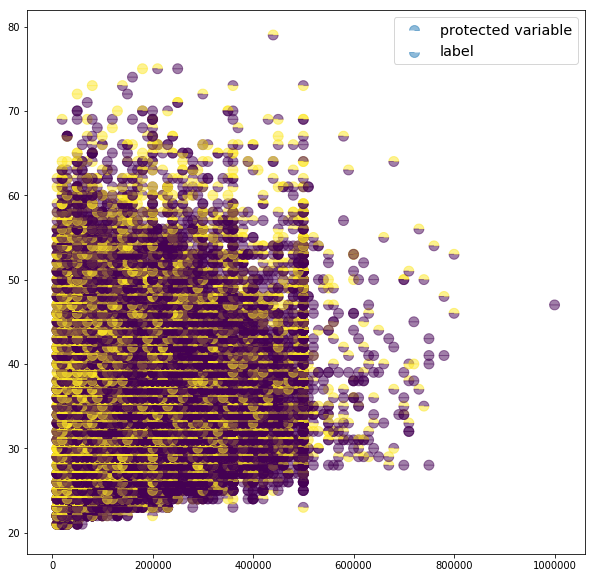

In [7]:
f, ax = plot_pies(data_train.values, protected_attribute, y_data, alpha=0.5)

In [16]:
#f.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/taiwan_credit_default.png', frameon=True, transparent=True, bbox_inches='tight')

In [17]:
for train_index, test_index in shuffle_splitter.split(data):
    data_train, data_test = data[train_index], data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    protected_train, protected_test = protected_attribute[train_index], protected_attribute[test_index]
    break

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [19]:
clf_base = RandomForestClassifier(class_weight='balanced')#random_state=random_seed)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5]
}
CLF_NAME = 'Random Forest'

In [20]:
# clf_base = GradientBoostingClassifier()

# param_grid = {
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'min_samples_split': [2, 3, 4, 5],
#     'max_depth':[None, 2, 3, 4, 5, 6]
# }
# CLF_NAME = 'Gradient Boosting'

In [21]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
# }
# CLF_NAME = 'Logistic Regression'

In [22]:
clf = GridSearchCV(clf_base, param_grid, scoring='f1', n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500, 1000], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [23]:
clf_predictions = clf.predict(data_test)

In [24]:
accuracy_before = accuracy_score(y_test, clf_predictions)
di_before = disparate_impact(clf_predictions, protected_test)
print('Initial accuracy of classification: {}'.format(accuracy_before))
print('Initial f1 of classification: {}'.format(f1_score(y_test, clf_predictions)))
print('Initial DI: {}'.format(di_before))

Initial accuracy of classification: 0.6962222222222222
Initial f1 of classification: 0.46538912788423936
Initial DI: 0.9104748102743027


In [25]:
negative_label = 0
positive_label = 1

In [26]:
male_entries_index = protected_train[protected_train == positive_label]
female_entries_index = protected_train[protected_train == negative_label]

male_entries_test_index = protected_test[protected_test == positive_label]
female_entries_test_index = protected_test[protected_test == negative_label]

n0 = data_train[protected_train == positive_label].shape[0]
n1 = data_train[protected_train == negative_label].shape[0]
n0_test = data_test[protected_test == positive_label].shape[0]
n1_test = data_test[protected_test == negative_label].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [27]:
C = ot.dist(data_test[protected_test == positive_label], data_test[protected_test == negative_label])

In [28]:
C /= C.max()

In [29]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 5.95 s, sys: 254 ms, total: 6.2 s
Wall time: 6.17 s


In [30]:
def f(G):
    return 0.5 * np.sum(G**2)

def df(G):
    return G

In [31]:
# coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg1=1e-3, reg2=1e-1, f=f, df=df, verbose=True)
# %time
# #coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]

In [49]:
coupling1 = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.05, stopThr=1e-9, verbose=True)

It.  |Err         
-------------------
    0|6.053073e-09|
   10|6.129028e-34|


In [50]:
coupling2 = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.05, verbose=10, numItermax=100000, stopThr=1e-9, m=1)

It.  |Err         
-------------------
    0|1.161875e-11|


In [34]:
y_first = y_test[protected_test == positive_label]
y_second = y_test[protected_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (3517,)
class 1 size (5483,)


In [35]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [36]:
from collections import defaultdict
from tqdm import tqdm

In [37]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

partial_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling2, y0, y1)
random_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling2, y0, y1, theta=rv)

In [38]:
protected_test_new = np.concatenate((np.ones(y_first.shape[0]), np.zeros(y_second.shape[0])))

In [39]:
evaluation_1 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [40]:
evaluation_2 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair full ot')#

100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [51]:
evaluation_3 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

 60%|██████    | 60/100 [00:15<00:10,  3.75it/s]/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / likelihood_ratio(y_predicted, protected)
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:60: RuntimeWarning: divide by zero encountered in long_scalars
  T_n = numerator / denominator
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  pi_1 / (pi_0 * p_1),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  -p_0 * pi_1 / (p_1**2 * pi_0),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  -p_0 * pi_1 / (p_1 * pi_0**2),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  p_0 / (p_1 * pi_0)
/

In [42]:
evaluation_4 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair regularized ot')

 99%|█████████▉| 99/100 [00:26<00:00,  3.74it/s]/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return d * (a + c) / c / (b + d)
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:60: RuntimeWarning: invalid value encountered in long_scalars
  T_n = numerator / denominator
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  pi_1 / (pi_0 * p_1),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:69: RuntimeWarning: invalid value encountered in double_scalars
  -p_0 * pi_1 / (p_1**2 * pi_0),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:70: RuntimeWarning: invalid value encountered in double_scalars
  -p_0 * pi_1 / (p_1 * pi_0**2),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:71: RuntimeWarning: invalid value encountered in double_scalars
  p_0 / (p_1 * pi_0)
/home/grapefroot/ot-numeri

In [43]:
evaluation_5 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, name='partial repair regularized ot')

 58%|█████▊    | 58/100 [00:15<00:11,  3.74it/s]/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return d * (a + c) / c / (b + d)
 85%|████████▌ | 85/100 [00:22<00:04,  3.75it/s]/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return d * (a + c) / c / (b + d)
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:60: RuntimeWarning: invalid value encountered in long_scalars
  T_n = numerator / denominator
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  pi_1 / (pi_0 * p_1),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:69: RuntimeWarning: invalid value encountered in double_scalars
  -p_0 * pi_1 / (p_1**2 * pi_0),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:70: RuntimeWarning: invalid value encountered in double_scal

In [44]:
evaluation_6 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair partial regularized ot')

 99%|█████████▉| 99/100 [00:26<00:00,  3.74it/s]/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return d * (a + c) / c / (b + d)
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:60: RuntimeWarning: invalid value encountered in long_scalars
  T_n = numerator / denominator
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  pi_1 / (pi_0 * p_1),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:69: RuntimeWarning: invalid value encountered in double_scalars
  -p_0 * pi_1 / (p_1**2 * pi_0),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:70: RuntimeWarning: invalid value encountered in double_scalars
  -p_0 * pi_1 / (p_1 * pi_0**2),
/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:71: RuntimeWarning: invalid value encountered in double_scalars
  p_0 / (p_1 * pi_0)
/home/grapefroot/ot-numeri

In [45]:
XX, yy = partial_repair_reg_func_pt(1, data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second)
disparate_impact(clf.predict(XX), protected_test_new)

/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return d * (a + c) / c / (b + d)


nan

In [46]:
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_1['Accuracy'][-1], evaluation_1['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_3['Accuracy'][-1], evaluation_3['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_5['Accuracy'][-1], evaluation_5['DI'][-1]))

Random Forest & 0.696 & 0.910 & 0.718 & 1.050
Random Forest & 0.696 & 0.910 & 0.780 & nan
Random Forest & 0.696 & 0.910 & 0.780 & nan


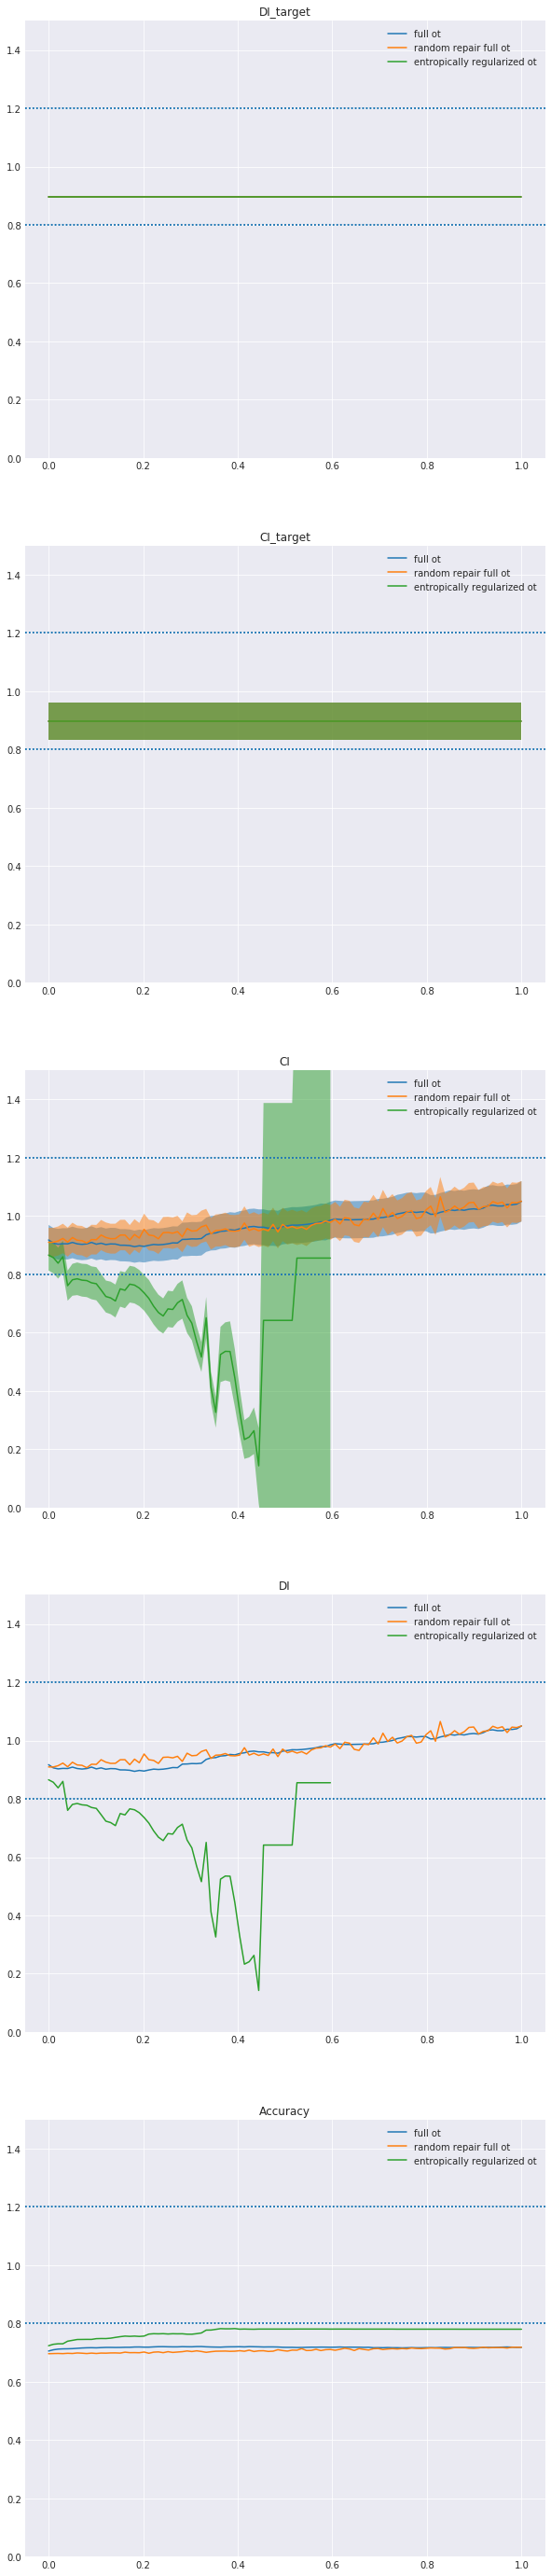

In [52]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3])

How to understand how many points are translated? Since we have that $1^\top \gamma 1 = m$, that means that 